# Notebook 02: Signal Generation Deep Dive
**Project:** Synthetic Sleep Environment Dataset Generator  
**Authors:** Rushav Dash & Lisa Li  
**Course:** TECHIN 513 — Signal Processing & Machine Learning  
**University:** University of Washington  
**Date:** 2026-02-19

## Table of Contents
1. [Setup & Imports](#section-1)
2. [One-session Temperature Walkthrough](#section-2)
3. [Light Signal Generation](#section-3)
4. [Sound and Humidity Signals](#section-4)
5. [Frequency Domain Analysis](#section-5)
6. [Multi-session Diversity](#section-6)
7. [Sensitivity Analysis — Light](#section-7)

---
## 1. Setup & Imports <a id='section-1'></a>
Import the signal generator and all supporting libraries. We also load reference statistics from the real datasets so the generator is calibrated to realistic ranges.

In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import signal as sp_signal

from src.signal_generator import SignalGenerator
from src.data_loader import DataLoader

%matplotlib inline
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})
sns.set_theme(style='whitegrid')

SEED      = 42
N_SAMPLES = 480  # 8 hours at 1-minute resolution
FS        = 1.0  # 1 sample per minute
t         = np.arange(N_SAMPLES) / 60.0  # time axis in hours

print(f'Session length : {N_SAMPLES} samples ({N_SAMPLES/60:.1f} hours)')
DT_MIN   = 5          # sampling interval in minutes
FS       = 1.0 / DT_MIN  # sampling frequency (cycles/min)


Session length : 480 samples (8.0 hours)


In [2]:
loader = DataLoader()
loader.download_all()

df_sleep = loader.load_sleep_efficiency()
df_occ   = loader.load_room_occupancy()
df_home  = loader.load_smart_home()

# Extract calibration statistics from real IoT data
ref_stats = loader.extract_reference_stats()

# Instantiate the signal generator with calibration stats
generator = SignalGenerator(ref_stats=ref_stats,
                            duration_minutes=480,
                            sampling_interval_minutes=5)
print('SignalGenerator ready.')
print(f'  Base temp range (winter): {ref_stats.temp_min:.1f}–{ref_stats.temp_max:.1f} °C')
print(f'  Autocorrelation lag-1:    {ref_stats.temp_autocorr_lag1:.3f}')

[DataLoader] Downloading Sleep Efficiency dataset…


[DataLoader]   Sleep Efficiency CSV: /home/rushav/.cache/kagglehub/datasets/equilibriumm/sleep-efficiency/versions/3/Sleep_Efficiency.csv
[DataLoader] Downloading Room Occupancy dataset…


[DataLoader]   Room Occupancy CSV: /home/rushav/.cache/kagglehub/datasets/kukuroo3/room-occupancy-detection-data-iot-sensor/versions/2/Occupancy.csv
[DataLoader] Downloading Smart Home dataset (optional)…


[DataLoader]   Smart Home CSV: /home/rushav/.cache/kagglehub/datasets/taranvee/smart-home-dataset-with-weather-information/versions/1/HomeC.csv
[DataLoader] Loaded Sleep Efficiency: 452 rows × 16 cols
[DataLoader] Loaded Room Occupancy: 20560 rows × 8 cols


[DataLoader] Loaded Smart Home: 503911 rows × 32 cols
SignalGenerator ready.
  Base temp range (winter): 19.4–21.0 °C
  Autocorrelation lag-1:    0.996


---
## 2. One-session Temperature Walkthrough <a id='section-2'></a>
We decompose the synthetic temperature signal into its constituent components:
- **T_base** — constant baseline (drawn from reference mean)
- **T_circadian** — slow sinusoidal drift modelling core-body-temperature-driven perception
- **T_hvac** — HVAC on/off cycling (square-wave + smoothing)
- **T_noise** — zero-mean Gaussian sensor noise
- **T_filtered** — final Butterworth low-pass filtered composite

In [3]:
rng = np.random.default_rng(SEED)

# --- Component 1: baseline ---
T_mean  = ref_stats.temp_mean
T_std   = ref_stats.temp_std
T_base  = np.full(N_SAMPLES, T_mean + rng.normal(0, T_std * 0.3))

# --- Component 2: circadian drift ---
circadian_amp   = rng.uniform(0.3, 0.8)
circadian_phase = rng.uniform(0, 2 * np.pi)
T_circadian     = circadian_amp * np.sin(2 * np.pi * t / 8.0 + circadian_phase)

# --- Component 3: HVAC cycling ---
hvac_period  = int(rng.integers(40, 80))  # minutes
hvac_amp     = rng.uniform(0.2, 0.6)
square_wave  = np.sign(np.sin(2 * np.pi * np.arange(N_SAMPLES) / hvac_period))
# Smooth the square wave to avoid discontinuities
kernel       = np.ones(10) / 10
T_hvac       = hvac_amp * np.convolve(square_wave, kernel, mode='same')

# --- Component 4: sensor noise ---
noise_std = 0.12  # typical indoor temperature noise std (°C)
T_noise   = rng.normal(0, noise_std, N_SAMPLES)

# --- Composite ---
T_raw = T_base + T_circadian + T_hvac + T_noise

# --- Component 5: Butterworth low-pass filter ---
# Butterworth LPF matching signal_generator.py approach
# fs = 1/5 samples/min, cutoff = 1/30 cycles/min
nyq = 0.5 / DT_MIN  # Nyquist = 0.1 cycles/min
cutoff_norm = min((1.0/30.0) / nyq, 0.9)
sos = sp_signal.butter(4, cutoff_norm, btype='low', output='sos')
T_filtered = sp_signal.sosfiltfilt(sos, T_raw)

print('Temperature components generated.')

Temperature components generated.


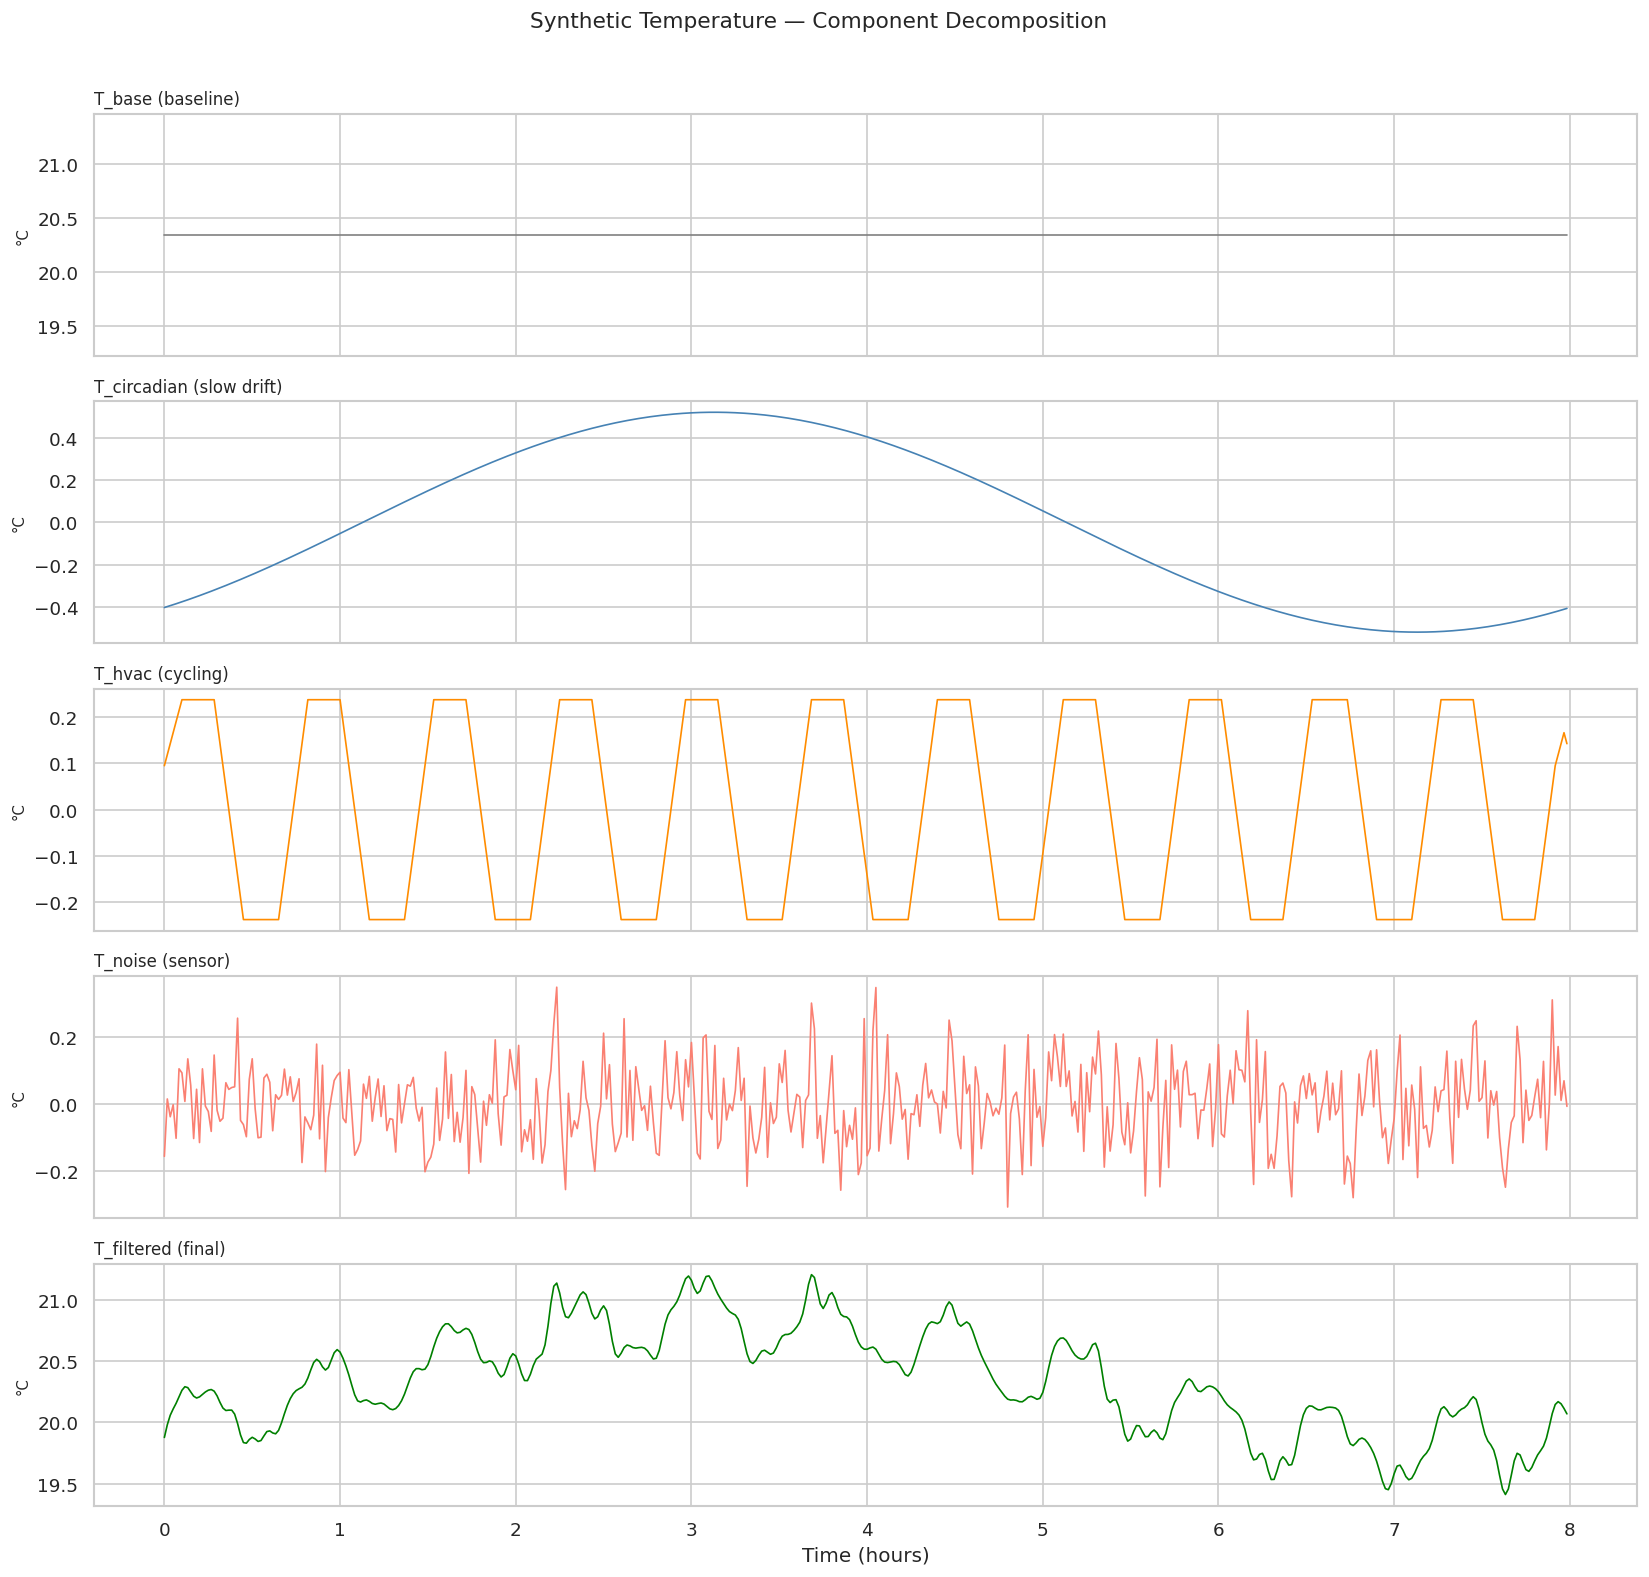

In [4]:
components  = [T_base, T_circadian, T_hvac, T_noise, T_filtered]
comp_labels = ['T_base (baseline)', 'T_circadian (slow drift)',
               'T_hvac (cycling)', 'T_noise (sensor)', 'T_filtered (final)']
colors      = ['gray', 'steelblue', 'darkorange', 'salmon', 'green']

fig, axes = plt.subplots(len(components), 1, figsize=(14, 2.6 * len(components)), sharex=True)
for ax, comp, label, color in zip(axes, components, comp_labels, colors):
    ax.plot(t, comp, color=color, linewidth=1.0)
    ax.set_ylabel('°C', fontsize=9)
    ax.set_title(label, fontsize=10, loc='left')

axes[-1].set_xlabel('Time (hours)')
fig.suptitle('Synthetic Temperature — Component Decomposition', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

---
## 3. Light Signal Generation Step-by-step <a id='section-3'></a>
The light signal is composed of a **background level** (near-zero for a sleeping environment) plus **discrete stochastic events** (e.g. partner switching on a lamp, moonlight through curtains).  
Event amplitudes and durations are drawn from calibrated reference distributions.

In [5]:
rng2 = np.random.default_rng(SEED + 1)

# --- Background ---
light_bg_mean = ref_stats.light_night_mean
light_bg_std  = ref_stats.light_night_std
L_background  = np.maximum(0, rng2.normal(light_bg_mean, light_bg_std, N_SAMPLES))

# --- Discrete events ---
event_rate      = (ref_stats.light_event_lambda / 480.0 / 5)  # prob per sample
event_signal    = np.zeros(N_SAMPLES)
event_positions = []

i = 0
while i < N_SAMPLES:
    if rng2.random() < event_rate:
        duration  = int(rng2.integers(2, 20))
        amplitude = rng2.uniform(5, 150)
        end       = min(i + duration, N_SAMPLES)
        event_signal[i:end] = amplitude
        event_positions.append((i, end, amplitude))
        i = end
    else:
        i += 1

# --- Composite light signal ---
L_total = L_background + event_signal

print(f'Number of light events generated : {len(event_positions)}')

Number of light events generated : 0


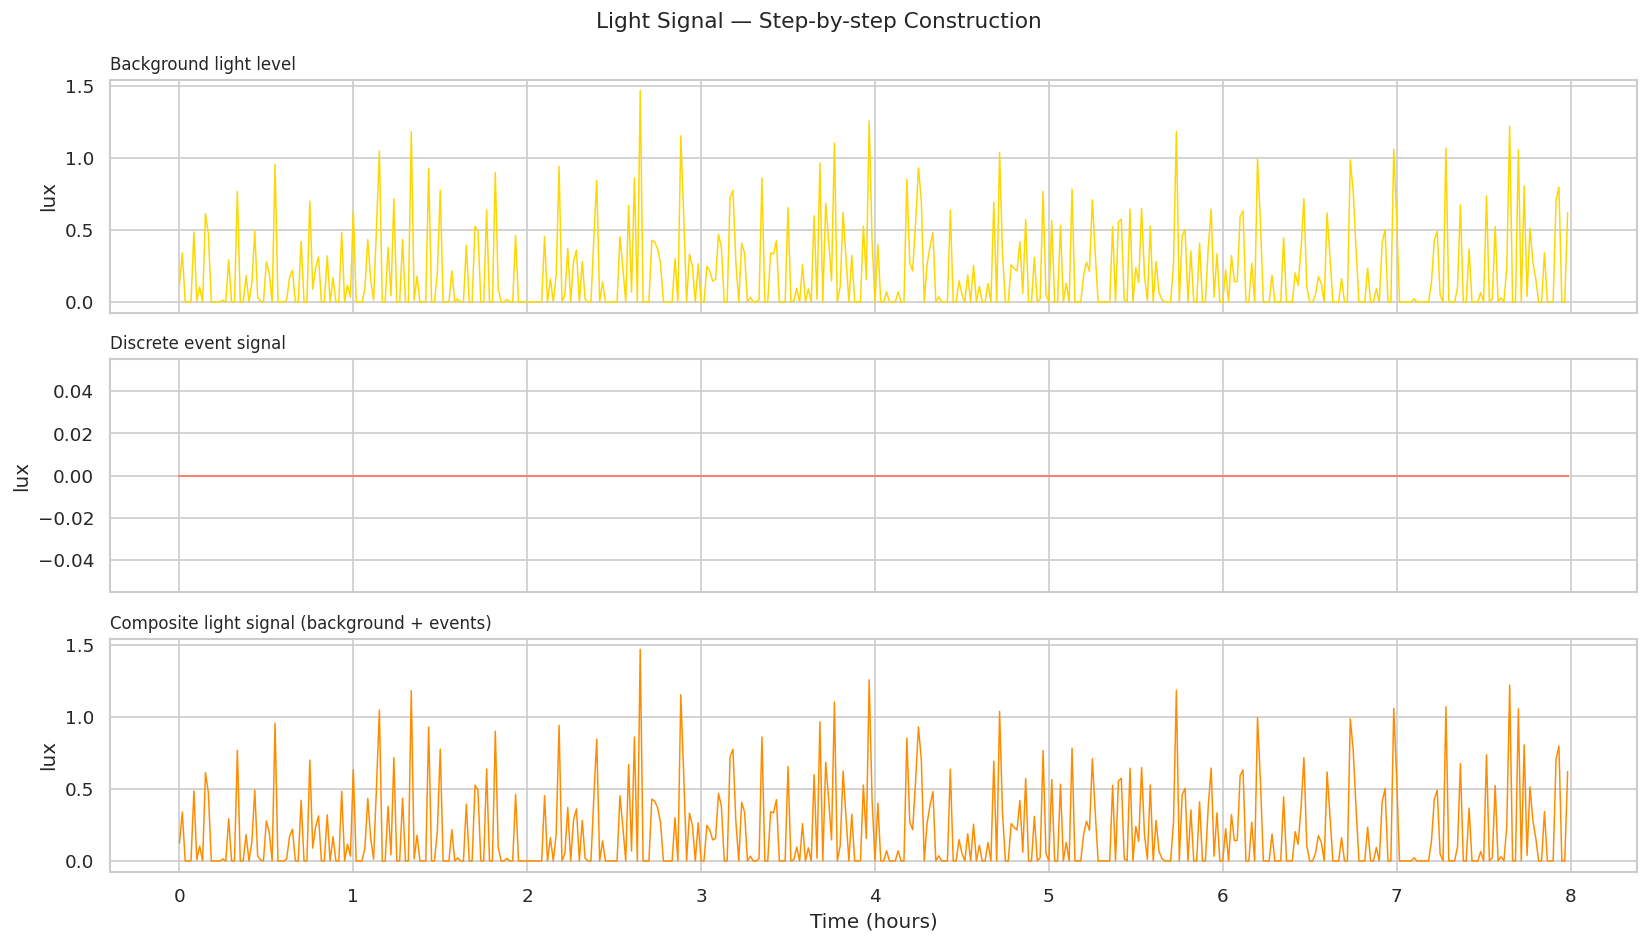

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

axes[0].plot(t, L_background, color='gold', linewidth=0.9)
axes[0].set_title('Background light level', loc='left', fontsize=10)
axes[0].set_ylabel('lux')

axes[1].fill_between(t, event_signal, color='tomato', alpha=0.7)
axes[1].set_title('Discrete event signal', loc='left', fontsize=10)
axes[1].set_ylabel('lux')

axes[2].plot(t, L_total, color='darkorange', linewidth=0.9)
axes[2].set_title('Composite light signal (background + events)', loc='left', fontsize=10)
axes[2].set_ylabel('lux')
axes[2].set_xlabel('Time (hours)')

fig.suptitle('Light Signal — Step-by-step Construction', fontsize=13)
plt.tight_layout()
plt.show()

---
## 4. Sound and Humidity Signals <a id='section-4'></a>
Sound is dominated by low-level broadband noise (snoring, HVAC hum) with rare spike events. Humidity follows a slow sinusoidal drift (breathing adds moisture) plus measurement noise.

In [7]:
rng3 = np.random.default_rng(SEED + 2)

# --- Sound ---
sound_base  = 35.0
sound_std   = 3.0
S_noise     = rng3.normal(sound_base, sound_std, N_SAMPLES)

# Rare spike events (e.g., door slam, snoring burst)
spike_mask  = rng3.random(N_SAMPLES) < 0.003
S_spikes    = spike_mask * rng3.uniform(15, 40, N_SAMPLES)
S_total     = np.maximum(0, S_noise + S_spikes)

# --- Humidity ---
hum_mean    = 50.0
hum_amp     = 3.0
hum_noise   = 0.5
H_drift     = hum_mean + hum_amp * np.sin(2 * np.pi * t / 8.0 + rng3.uniform(0, 2 * np.pi))
H_total     = H_drift + rng3.normal(0, hum_noise, N_SAMPLES)
H_total     = np.clip(H_total, 20, 95)

print('Sound and humidity signals generated.')

Sound and humidity signals generated.


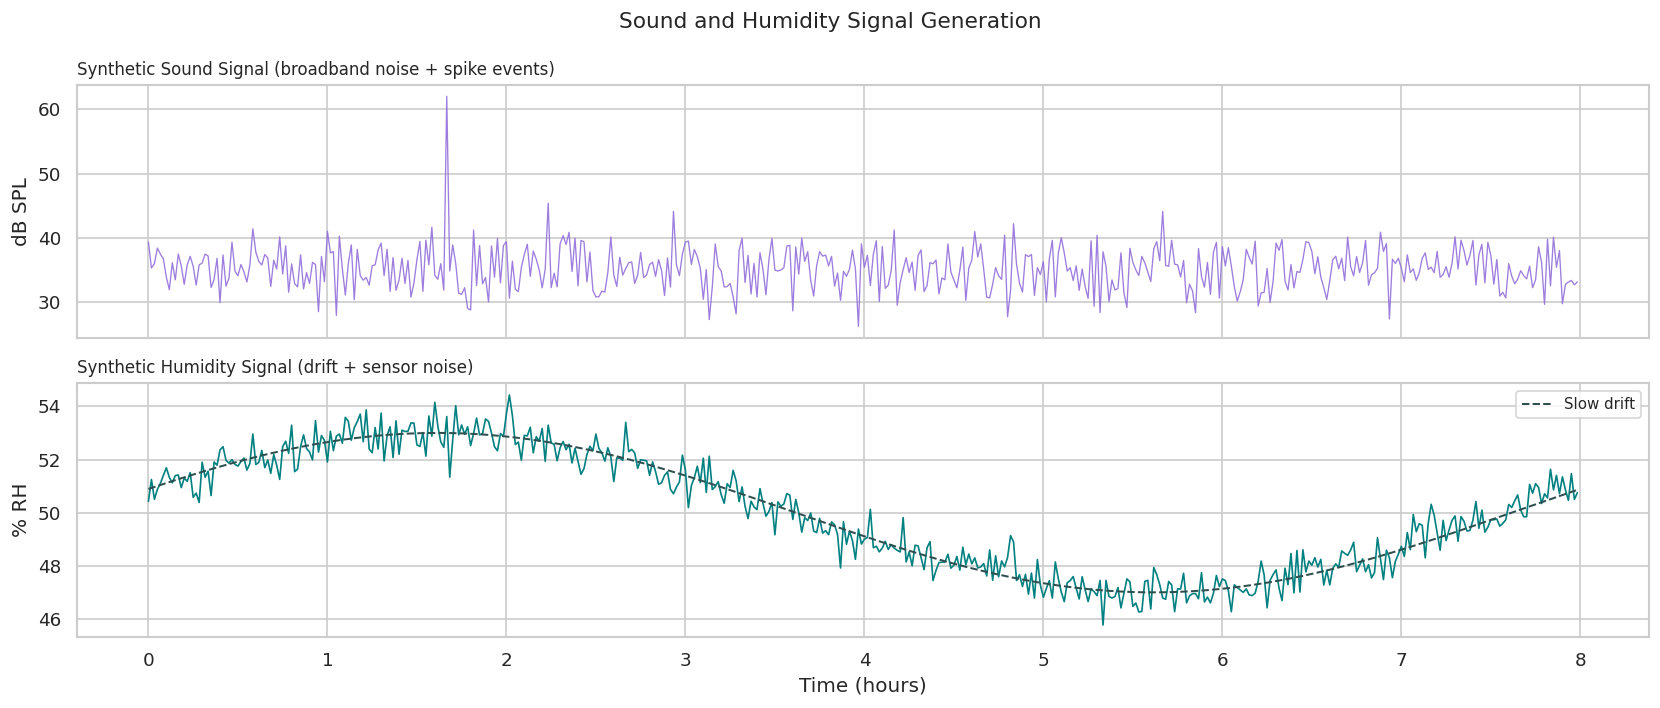

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

ax1.plot(t, S_total, color='mediumpurple', linewidth=0.8, alpha=0.9)
ax1.set_ylabel('dB SPL')
ax1.set_title('Synthetic Sound Signal (broadband noise + spike events)', loc='left', fontsize=10)

ax2.plot(t, H_total, color='teal', linewidth=1.0)
ax2.plot(t, H_drift, color='darkslategray', linewidth=1.2, linestyle='--', label='Slow drift')
ax2.set_ylabel('% RH')
ax2.set_xlabel('Time (hours)')
ax2.set_title('Synthetic Humidity Signal (drift + sensor noise)', loc='left', fontsize=10)
ax2.legend(fontsize=9)

fig.suptitle('Sound and Humidity Signal Generation', fontsize=13)
plt.tight_layout()
plt.show()

---
## 5. Frequency Domain Analysis <a id='section-5'></a>
Compare the power spectral density (PSD) of the **synthetic temperature** against the **real room occupancy temperature** to verify that the generator preserves key frequency structure.

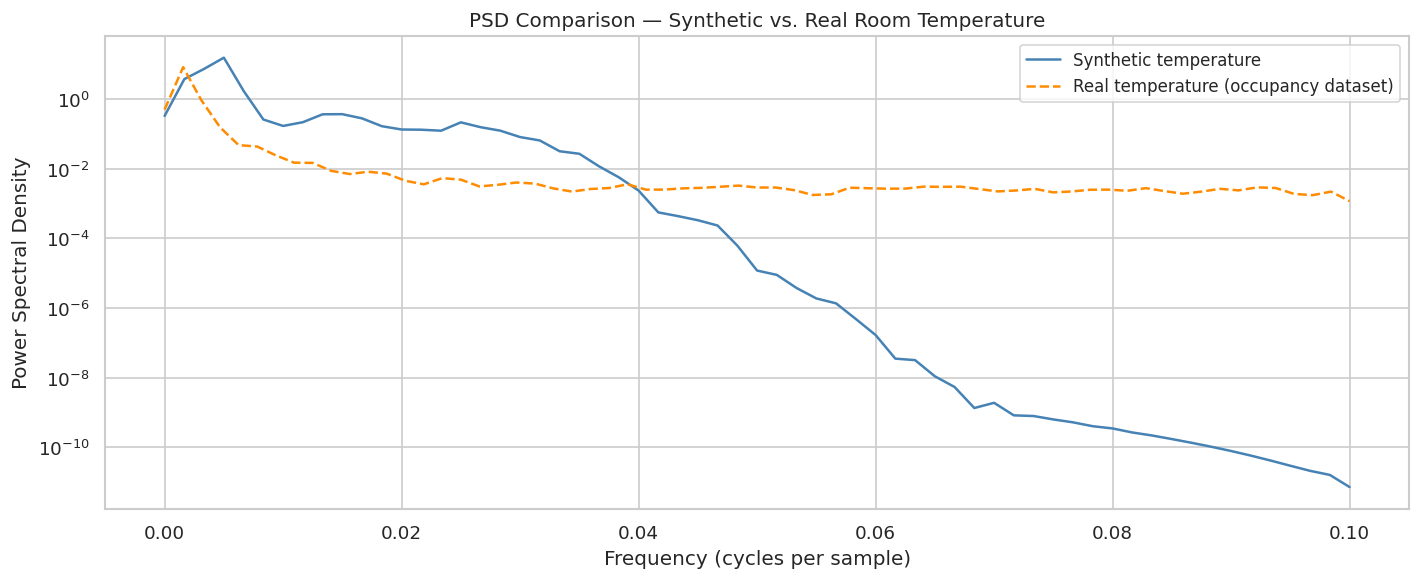

In [9]:
# PSD of synthetic temperature
f_syn, psd_syn = sp_signal.welch(T_filtered, fs=FS, nperseg=min(128, N_SAMPLES // 4))

# PSD of real temperature (use first 2000 samples)
temp_col = next((c for c in df_occ.columns if 'temp' in c.lower()), None)
real_temp_vals = df_occ[temp_col].dropna().values[:2000] if temp_col else None

fig, ax = plt.subplots(figsize=(12, 5))
ax.semilogy(f_syn, psd_syn, label='Synthetic temperature', color='steelblue', linewidth=1.5)

if real_temp_vals is not None and len(real_temp_vals) > 10:
    f_real, psd_real = sp_signal.welch(real_temp_vals - real_temp_vals.mean(),
                                        fs=FS, nperseg=min(128, len(real_temp_vals) // 4))
    ax.semilogy(f_real, psd_real, label='Real temperature (occupancy dataset)',
                color='darkorange', linewidth=1.5, linestyle='--')

ax.set_xlabel('Frequency (cycles per sample)')
ax.set_ylabel('Power Spectral Density')
ax.set_title('PSD Comparison — Synthetic vs. Real Room Temperature')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

---
## 6. Multi-session Diversity <a id='section-6'></a>
Generate 5 independent temperature signals with different random seeds and overlay them.  
This demonstrates that the generator produces **plausible session-to-session variability** — no two nights look identical.

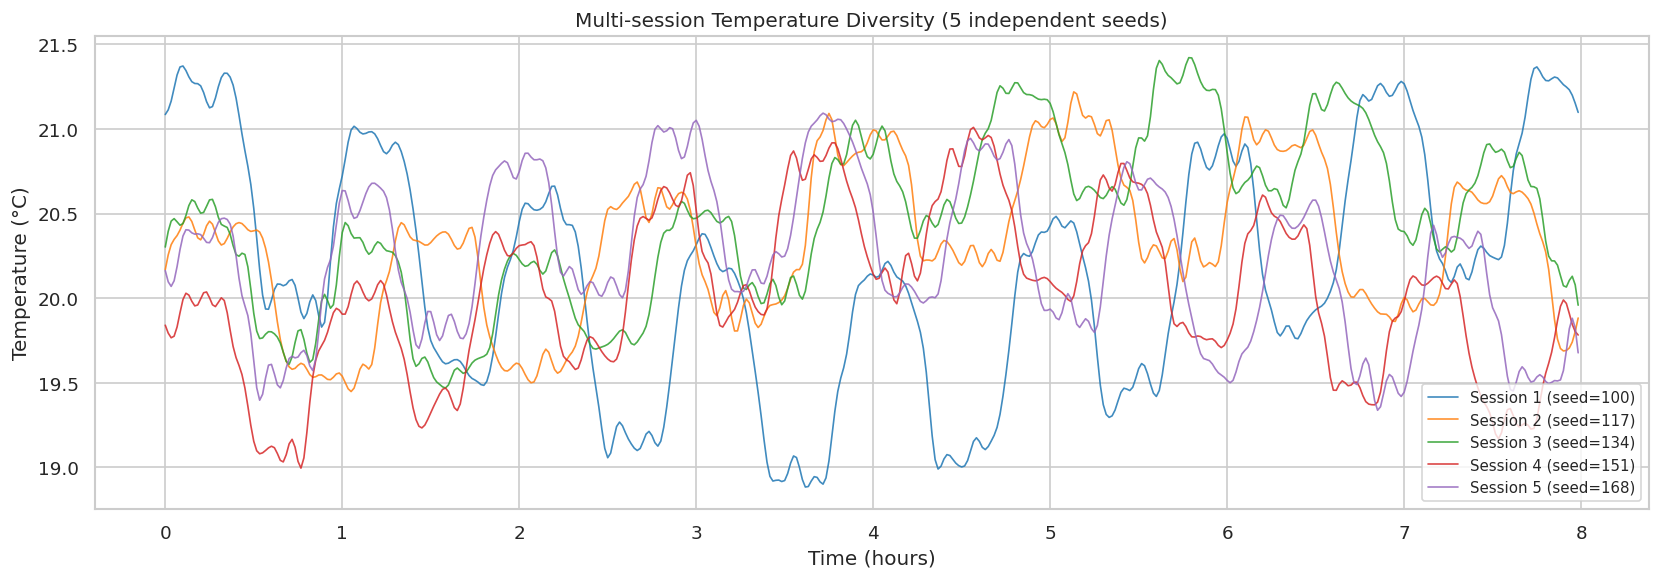

In [10]:
N_SESSIONS = 5
session_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, ax = plt.subplots(figsize=(14, 5))

for i in range(N_SESSIONS):
    rng_s = np.random.default_rng(100 + i * 17)

    T_b = np.full(N_SAMPLES, T_mean + rng_s.normal(0, T_std * 0.3))
    T_c = rng_s.uniform(0.3, 0.8) * np.sin(
        2 * np.pi * t / 8.0 + rng_s.uniform(0, 2 * np.pi)
    )
    hp  = int(rng_s.integers(40, 80))
    sq  = np.sign(np.sin(2 * np.pi * np.arange(N_SAMPLES) / hp))
    T_h = rng_s.uniform(0.2, 0.6) * np.convolve(sq, np.ones(10) / 10, mode='same')
    T_n = rng_s.normal(0, noise_std, N_SAMPLES)
    T_r = T_b + T_c + T_h + T_n
    # Use same SOS filter as signal_generator.py
    sos_s = sp_signal.butter(4, cutoff_norm, btype='low', output='sos')
    T_f = sp_signal.sosfiltfilt(sos_s, T_r)

    ax.plot(t, T_f, color=session_colors[i], linewidth=1.0, alpha=0.85,
            label=f'Session {i + 1} (seed={100 + i * 17})')

ax.set_xlabel('Time (hours)')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Multi-session Temperature Diversity (5 independent seeds)')
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

---
## 7. Sensitivity Analysis — Light Signal <a id='section-7'></a>
Some individuals are highly sensitive to light disturbances during sleep.  
We simulate three sensitivity profiles — **low**, **normal**, and **high** — by scaling the event amplitude and rate.

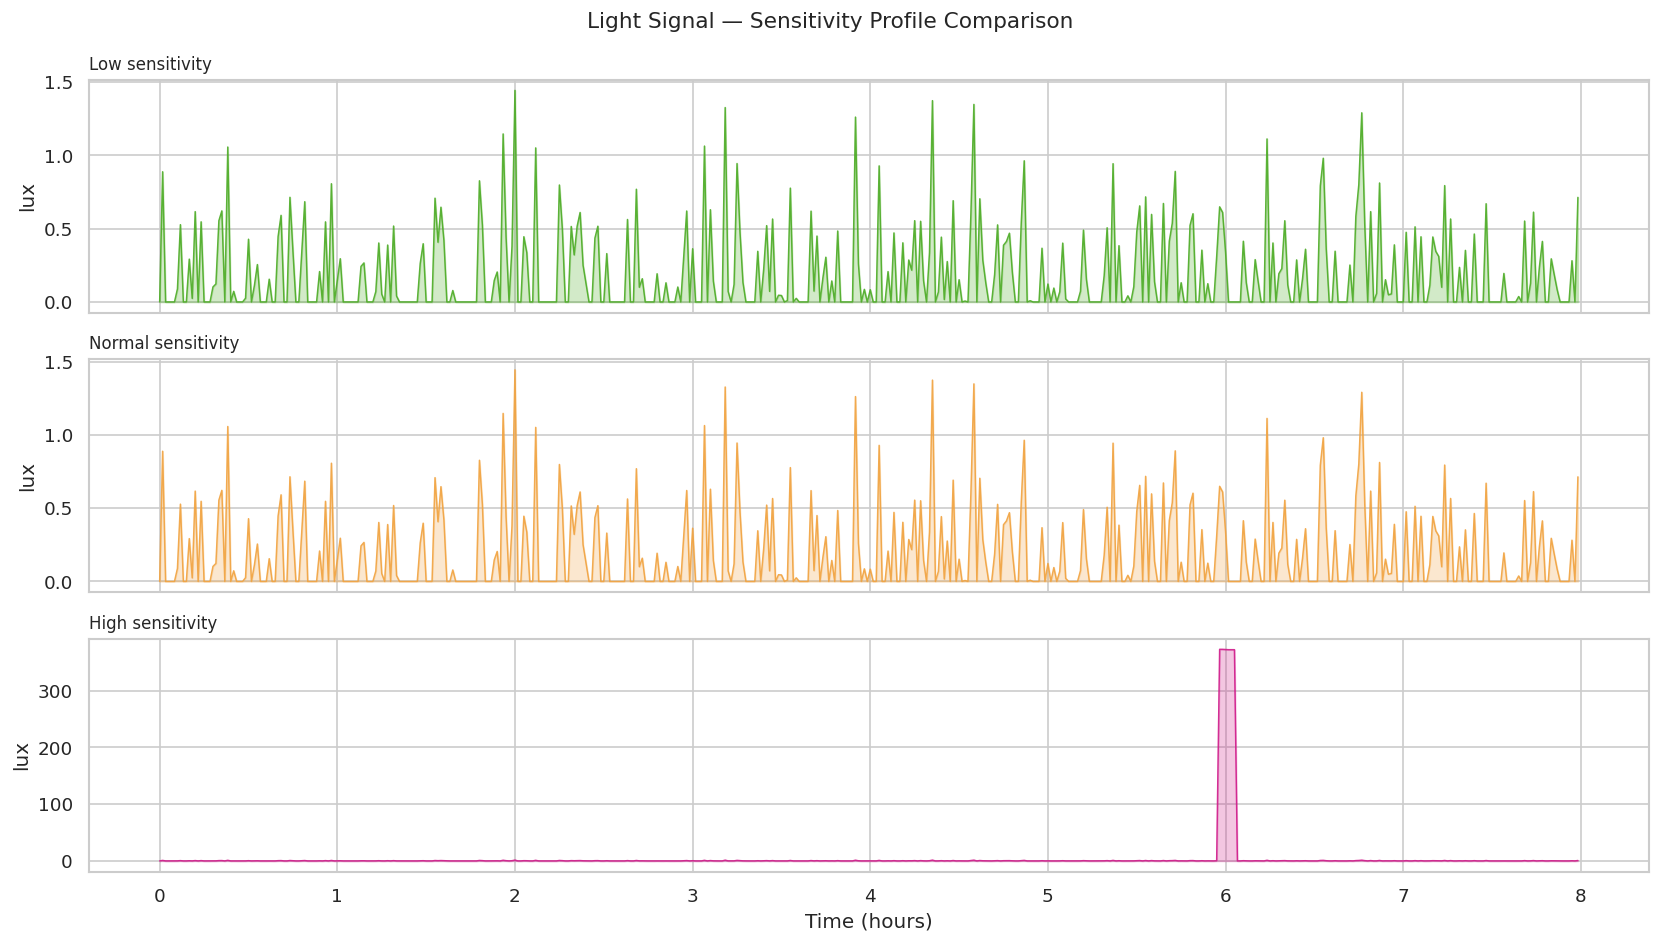

In [11]:
sensitivity_profiles = {
    'Low sensitivity'   : {'rate_factor': 0.5,  'amp_factor': 0.4},
    'Normal sensitivity': {'rate_factor': 1.0,  'amp_factor': 1.0},
    'High sensitivity'  : {'rate_factor': 2.0,  'amp_factor': 2.5},
}

fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True, sharey=False)
palette   = ['#4dac26', '#f1a340', '#d01c8b']

for ax, (label, params), color in zip(axes, sensitivity_profiles.items(), palette):
    rng_l = np.random.default_rng(SEED + 99)
    bg    = np.maximum(0, rng_l.normal(light_bg_mean, light_bg_std, N_SAMPLES))
    evs   = np.zeros(N_SAMPLES)
    j     = 0
    while j < N_SAMPLES:
        if rng_l.random() < event_rate * params['rate_factor']:
            dur = int(rng_l.integers(2, 20))
            amp = rng_l.uniform(5, 150) * params['amp_factor']
            end = min(j + dur, N_SAMPLES)
            evs[j:end] = amp
            j = end
        else:
            j += 1
    L_profile = bg + evs
    ax.plot(t, L_profile, color=color, linewidth=0.9, alpha=0.9)
    ax.fill_between(t, L_profile, alpha=0.25, color=color)
    ax.set_title(label, fontsize=10, loc='left')
    ax.set_ylabel('lux')

axes[-1].set_xlabel('Time (hours)')
fig.suptitle('Light Signal — Sensitivity Profile Comparison', fontsize=13)
plt.tight_layout()
plt.show()

In [12]:
print('Notebook 02 complete.')

Notebook 02 complete.
